# Imports

In [132]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
import seaborn as sns


# Reading and processing data


In [239]:
income_data = pd.read_csv("adult.csv", na_values="?")

# Age groups (binning)
income_data['age_group'] = pd.cut(income_data['age'], 
                         bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Capital gains/loss flags (many zeros)
income_data['has_capital_gain'] = (income_data['capital.gain'] > 0).astype(int)
income_data['has_capital_loss'] = (income_data['capital.loss'] > 0).astype(int)

# Total capital
income_data['capital_total'] = income_data['capital.gain'] - income_data['capital.loss']

# Hours per week categories
income_data['hours_category'] = pd.cut(income_data['hours.per.week'],
                              bins=[0, 20, 30, 40, 50, 60, 100],
                              labels=['part-time', 'reduced', 'full-time', 
                                     'over-time', 'extreme', 'excessive'])

# Work class simplification
income_data['workclass_simple'] = income_data['workclass'].replace({
    'Never-worked': 'Other',
    'Without-pay': 'Other',
    '?': 'Unknown'
})

In [240]:
# income_data.describe()
income_data.info()
income_data.columns = range(len(income_data.columns))
income_data.columns = income_data.columns.astype(str)

income_data = income_data.dropna()
income_data_labels = income_data["14"]
income_data = income_data.drop(columns=["14"])
# income_data.info()

income_data.head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               32561 non-null  int64   
 1   workclass         30725 non-null  object  
 2   fnlwgt            32561 non-null  int64   
 3   education         32561 non-null  object  
 4   education.num     32561 non-null  int64   
 5   marital.status    32561 non-null  object  
 6   occupation        30718 non-null  object  
 7   relationship      32561 non-null  object  
 8   race              32561 non-null  object  
 9   sex               32561 non-null  object  
 10  capital.gain      32561 non-null  int64   
 11  capital.loss      32561 non-null  int64   
 12  hours.per.week    32561 non-null  int64   
 13  native.country    31978 non-null  object  
 14  income            32561 non-null  object  
 15  age_group         32561 non-null  category
 16  has_capital_gain  3256

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,65+,0,1,-4356,part-time,Private
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,46-55,0,1,-3900,full-time,Private
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,36-45,0,1,-3900,full-time,Private
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,26-35,0,1,-3770,over-time,Private
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,36-45,0,1,-3770,full-time,Private
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,65+,0,1,-3683,part-time,State-gov
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,65+,0,1,-3683,full-time,Federal-gov
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,36-45,0,1,-3004,full-time,Private
11,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,36-45,0,1,-2824,over-time,Self-emp-not-inc
12,52,Private,129177,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,0,2824,20,United-States,46-55,0,1,-2824,part-time,Private


In [241]:
# imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# imputer.fit(income_data)
# income_data = imputer.transform(income_data)

In [242]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

# Apply to all numeric columns
numeric_cols = income_data.select_dtypes(include=['int64', 'float64']).columns


def log_transform(df, column):
    # Add small constant if there are zeros
    if (df[column] == 0).any():
        df[f"{column}" + '_log'] = np.log1p(df[column])
    else:
        df[f"{column}" + '_log'] = np.log(df[column])
    return df

In [243]:
# Calculate skewness for numeric columns

for col in numeric_cols:
    skewness = income_data[col].skew()
    
    # Interpret skewness
    if abs(skewness) < 0.5:
        interpretation = "Approximately symmetric"
    elif abs(skewness) < 1:
        interpretation = "Moderately skewed"
        income_data = log_transform(income_data, col)
    else:
        interpretation = "Highly skewed"
        income_data = cap_outliers(income_data, col)
    
    print(f"{col}: Skewness = {skewness:.2f} - {interpretation}")

0: Skewness = 0.53 - Moderately skewed
2: Skewness = 1.46 - Highly skewed
4: Skewness = -0.31 - Approximately symmetric
10: Skewness = 11.90 - Highly skewed
11: Skewness = 4.53 - Highly skewed
12: Skewness = 0.33 - Approximately symmetric
16: Skewness = 3.00 - Highly skewed
17: Skewness = 4.26 - Highly skewed
18: Skewness = 11.82 - Highly skewed


<Axes: >

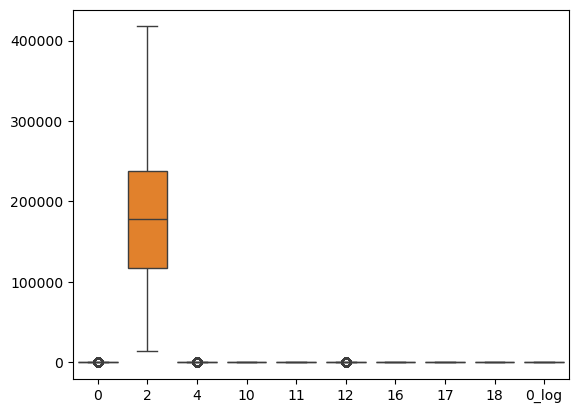

In [244]:
sns.boxplot(income_data)

In [245]:
# income_data = pd.DataFrame(income_data)
income_data.info()
income_data.head(15)
# income_data.shape

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   0       30162 non-null  int64   
 1   1       30162 non-null  object  
 2   2       30162 non-null  float64 
 3   3       30162 non-null  object  
 4   4       30162 non-null  int64   
 5   5       30162 non-null  object  
 6   6       30162 non-null  object  
 7   7       30162 non-null  object  
 8   8       30162 non-null  object  
 9   9       30162 non-null  object  
 10  10      30162 non-null  int64   
 11  11      30162 non-null  int64   
 12  12      30162 non-null  int64   
 13  13      30162 non-null  object  
 14  15      30162 non-null  category
 15  16      30162 non-null  int64   
 16  17      30162 non-null  int64   
 17  18      30162 non-null  int64   
 18  19      30162 non-null  category
 19  20      30162 non-null  object  
 20  0_log   30162 non-null  float64 
dtypes: category(2), f

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,15,16,17,18,19,20,0_log
1,82,Private,132870.000,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,0,18,United-States,65+,0,0,0,part-time,Private,4.406719
3,54,Private,140359.000,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,0,40,United-States,46-55,0,0,0,full-time,Private,3.988984
4,41,Private,264663.000,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,0,40,United-States,36-45,0,0,0,full-time,Private,3.713572
5,34,Private,216864.000,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,0,45,United-States,26-35,0,0,0,over-time,Private,3.526361
6,38,Private,150601.000,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,0,40,United-States,36-45,0,0,0,full-time,Private,3.637586
7,74,State-gov,88638.000,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,...,0,20,United-States,65+,0,0,0,part-time,State-gov,4.304065
8,68,Federal-gov,417630.375,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,...,0,40,United-States,65+,0,0,0,full-time,Federal-gov,4.219508
10,45,Private,172274.000,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,...,0,35,United-States,36-45,0,0,0,full-time,Private,3.806662
11,38,Self-emp-not-inc,164526.000,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,...,0,45,United-States,36-45,0,0,0,over-time,Self-emp-not-inc,3.637586
12,52,Private,129177.000,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,...,0,20,United-States,46-55,0,0,0,part-time,Private,3.951244


In [246]:
le1 = LabelEncoder()
le3 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()
le7 = LabelEncoder()
le8 = LabelEncoder()
le9 = LabelEncoder()
le13 = LabelEncoder()
le15 = LabelEncoder()
le18 = LabelEncoder()
le17 = LabelEncoder()
le20 = LabelEncoder()
le19 = LabelEncoder()
target_label_encoder = LabelEncoder()


income_data["1"] = le1.fit_transform(income_data["1"])
income_data["3"] = le3.fit_transform(income_data["3"])
income_data["5"] = le5.fit_transform(income_data["5"])
income_data["6"] = le6.fit_transform(income_data["6"])
income_data["7"] = le7.fit_transform(income_data["7"])
income_data["8"] = le8.fit_transform(income_data["8"])
income_data["9"] = le9.fit_transform(income_data["9"])
income_data["13"] = le13.fit_transform(income_data["13"])
income_data["15"] = le15.fit_transform(income_data["15"])
income_data["18"] = le18.fit_transform(income_data["18"])
income_data["17"] = le17.fit_transform(income_data["17"])
income_data["20"] = le20.fit_transform(income_data["20"])
income_data["19"] = le19.fit_transform(income_data["19"])
income_data_labels = target_label_encoder.fit_transform(income_data_labels)
income_data.head(15)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,15,16,17,18,19,20,0_log
1,82,2,132870.000,11,9,6,3,1,4,0,...,0,18,38,5,0,0,0,4,3,4.406719
3,54,2,140359.000,5,4,0,6,4,4,0,...,0,40,38,3,0,0,0,2,3,3.988984
4,41,2,264663.000,15,10,5,9,3,4,0,...,0,40,38,2,0,0,0,2,3,3.713572
5,34,2,216864.000,11,9,0,7,4,4,0,...,0,45,38,1,0,0,0,3,3,3.526361
6,38,2,150601.000,0,6,5,0,4,4,1,...,0,40,38,2,0,0,0,2,3,3.637586
7,74,5,88638.000,10,16,4,9,2,4,0,...,0,20,38,5,0,0,0,4,6,4.304065
8,68,0,417630.375,11,9,0,9,1,4,0,...,0,40,38,5,0,0,0,2,0,4.219508
10,45,2,172274.000,10,16,0,9,4,2,0,...,0,35,38,2,0,0,0,2,3,3.806662
11,38,4,164526.000,14,15,4,9,1,4,1,...,0,45,38,2,0,0,0,3,5,3.637586
12,52,2,129177.000,9,13,6,7,1,4,0,...,0,20,38,3,0,0,0,4,3,3.951244


In [247]:
from imblearn.over_sampling import SMOTE
from collections import Counter



# Apply SMOTE
smote = SMOTE(random_state=42)
income_data, income_data_labels = smote.fit_resample(income_data, income_data_labels)

# print(f"Original: {Counter(income_data_labels)}")
print(f"SMOTE: {Counter(income_data_labels)}")

SMOTE: Counter({np.int64(0): 22654, np.int64(1): 22654})


In [248]:
income_data.head(15)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,15,16,17,18,19,20,0_log
0,82,2,132870.000,11,9,6,3,1,4,0,...,0,18,38,5,0,0,0,4,3,4.406719
1,54,2,140359.000,5,4,0,6,4,4,0,...,0,40,38,3,0,0,0,2,3,3.988984
2,41,2,264663.000,15,10,5,9,3,4,0,...,0,40,38,2,0,0,0,2,3,3.713572
3,34,2,216864.000,11,9,0,7,4,4,0,...,0,45,38,1,0,0,0,3,3,3.526361
4,38,2,150601.000,0,6,5,0,4,4,1,...,0,40,38,2,0,0,0,2,3,3.637586
5,74,5,88638.000,10,16,4,9,2,4,0,...,0,20,38,5,0,0,0,4,6,4.304065
6,68,0,417630.375,11,9,0,9,1,4,0,...,0,40,38,5,0,0,0,2,0,4.219508
7,45,2,172274.000,10,16,0,9,4,2,0,...,0,35,38,2,0,0,0,2,3,3.806662
8,38,4,164526.000,14,15,4,9,1,4,1,...,0,45,38,2,0,0,0,3,5,3.637586
9,52,2,129177.000,9,13,6,7,1,4,0,...,0,20,38,3,0,0,0,4,3,3.951244


In [249]:
sc = StandardScaler()
income_data.iloc[:,0:14] = sc.fit_transform(income_data.iloc[:,0:14])

/tmp/ipykernel_5771/3487410370.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.49362149  1.15923366  0.07541075 ...  0.15878174  0.7423787
 -0.34144422]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  income_data.iloc[:,0:14] = sc.fit_transform(income_data.iloc[:,0:14])
/tmp/ipykernel_5771/3487410370.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.12943408 -0.12943408 -0.12943408 ... -0.12943408  0.96487441
 -0.12943408]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  income_data.iloc[:,0:14] = sc.fit_transform(income_data.iloc[:,0:14])
/tmp/ipykernel_5771/3487410370.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.18423976 -1.58843704  1.36602429 ... -1.2929909  -0.11

In [250]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier


X_train, X_test, Y_train, Y_test = train_test_split(income_data.iloc[:,0:14], income_data_labels, test_size=0.2, shuffle=True)

lr = XGBClassifier()
param_grid = {"n_estimators":[1,2,3,4,5,6], "max_depth":[1,2,3,4,5,6], "learning_rate":[1,2,3,4,5,6], "objective":'binary:logistic'}
models = GridSearchCV(lr, param_grid={})
models.fit(X_train, Y_train)
# print(X_train.shape, Y_train.shape)
# model.fit(X_train, Y_train)
model = models.best_estimator_

Accuracy: 0.8790553961597881


<Axes: >

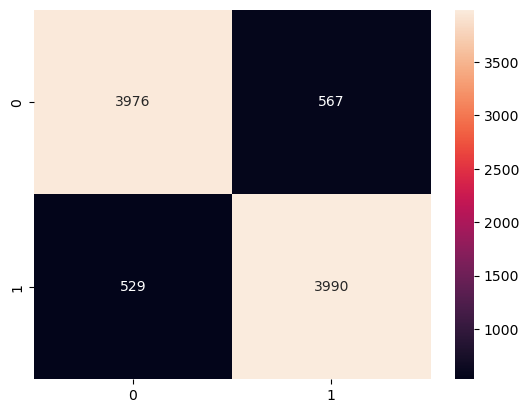

In [251]:
from sklearn.metrics import confusion_matrix, accuracy_score
predictions = model.predict(X_test)
score = accuracy_score(Y_test, predictions)
cm = confusion_matrix(Y_test, predictions)
print("Accuracy:", score)
sns.heatmap(cm, annot=True, fmt="d")